In [1]:
print("test")

test


# Download the csv data to the raw data folder

In [ ]:
import requests, zipfile, io
url = 'https://github.com/rgap/NMA-Twitter-SentimentAnalysis/raw/main/data/raw/trainingandtestdata.zip'
raw_data_directory = 'data/raw/'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(path=raw_data_directory)

# 1. Read the CSV

Reading the only data we will use for this project

In [ ]:
import pandas as pd

raw_data_directory = 'data/raw/'

# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
# We load the dataset (THIS WILL USE ONLY THE TRAINING DATASET)
df = pd.read_csv(raw_data_directory + 'training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Let's have a look at it
df.head(2)

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


# 2. Questions and goals

## 2.2. Research Questions

- Can we infer emotion from a tweet text?
- How do words are distributed accross the dataset?
- Are words related to one kind of emotion?

- Look at the polarity distribution

## 2.1. Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

## 3. Data Analysis

In [ ]:
#visualize the infromation in the columns
print(df.shape)

(1600000, 6)


## 4. Understanding the columns

### 4.1. Polarity

Polarity means a large difference from the middle

- 0: Negative sentiment (Negatively Polar Opinion)
- 2: Neutral sentiment
- 4: Positive sentiment (Positively Polar Opinion)

### 4.2. id

Unique identifier

### 4.3. Date

Posting date

### TODO: Query, user are omitted

### 4.4. Text

Tweet text

## 5. Analyzing the columns

In [ ]:
def analyze_columns(df, unique_ratio_threshold=0.001):
    """
    This function analyzes each column of a DataFrame and provides detailed information about each one,
    including an estimate of whether it is categorical based on the proportion of unique values.

    Parameters:
    df (DataFrame): The DataFrame to analyze.
    unique_ratio_threshold (float): The maximum proportion of unique values relative to the total number of rows to consider a column as categorical (default is 0.001).

    Returns:
    tuple: Two DataFrames, one with the analysis of categorical columns, another with the analysis of non-categorical columns,
           and a dictionary indicating whether each column is categorical or not.
    """
    # Initialize lists to store results
    categorical_results = []
    non_categorical_results = []

    # Total number of rows in the DataFrame
    num_rows = df.shape[0]

    # Analyze each column
    for column in df.columns:
        data_type = df[column].dtype
        num_unique = df[column].nunique()
        unique_ratio = round(num_unique / num_rows, 3)
        mode = df[column].mode().iloc[0] if not df[column].mode().empty else None

        # Calculate the probability of being categorical based on the proportion of unique values
        categorical_probability = round(1 - unique_ratio, 3)
        is_categorical = unique_ratio <= unique_ratio_threshold
        category = "Categorical" if is_categorical else "Numerical"

        if data_type in ['int64', 'float64']:
            minimum = round(df[column].min(), 3)
            maximum = round(df[column].max(), 3)
        else:
            minimum = df[column].min()
            maximum = df[column].max()

        if is_categorical:
            categorical_results.append({
                'Column': column,
                'Data Type': data_type,
                'Unique Values': num_unique,
                'Unique Value Ratio': unique_ratio,
                'Categorical Probability': categorical_probability,
                'Mode': mode,
                'Minimum Value': minimum,
                'Maximum Value': maximum
            })
        else:
            if data_type in ['int64', 'float64']:
                mean = round(df[column].mean(), 3)
                median = round(df[column].median(), 3)
                std_dev = round(df[column].std(), 3)
                q1 = round(df[column].quantile(0.25), 3)
                q3 = round(df[column].quantile(0.75), 3)
            else:
                mean = None
                median = None
                std_dev = None
                q1 = None
                q3 = None

            non_categorical_results.append({
                'Column': column,
                'Data Type': data_type,
                'Unique Values': num_unique,
                'Unique Value Ratio': unique_ratio,
                'Categorical Probability': categorical_probability,
                'Minimum Value': minimum,
                'Maximum Value': maximum,
                'First Quartile (Q1)': q1,
                'Third Quartile (Q3)': q3,
                'Mode': mode,
                'Mean': mean,
                'Median': median,
                'Standard Deviation': std_dev,
            })

    # Convert result lists to DataFrames
    categorical_indicators = pd.DataFrame(categorical_results)
    non_categorical_indicators = pd.DataFrame(non_categorical_results)

    return categorical_indicators, non_categorical_indicators


## 5.1. Categorical Data

In [ ]:
categorical_indicators, non_categorical_indicators = analyze_columns(df, unique_ratio_threshold=0.001)
categorical_indicators

,Column,Data Type,Unique Values,Unique Value Ratio,Categorical Probability,Mode,Minimum Value,Maximum Value
0,polarity,int64,2,0.0,1.0,0,0,4
1,query,object,1,0.0,1.0,NO_QUERY,NO_QUERY,NO_QUERY


In [ ]:
categorical_columns = categorical_indicators["Column"].values
df[categorical_columns].head(3)

,polarity,query
0,0,NO_QUERY
1,0,NO_QUERY
2,0,NO_QUERY


In [ ]:
print("\nUnique values of each categorical column:\n")
for column in categorical_indicators['Column']:
    print(f"{column}\t", df[column].unique().tolist())


Unique values of each categorical column:

polarity	 [0, 4]
query	 ['NO_QUERY']


## 5.2. Non-categorical Data

In [ ]:
non_categorical_indicators

,Column,Data Type,Unique Values,Unique Value Ratio,Categorical Probability,Minimum Value,Maximum Value,First Quartile (Q1),Third Quartile (Q3),Mode,Mean,Median,Standard Deviation
0,id,int64,1598315,0.999,0.001,1467810369,2329205794,1.956916e+09,2.177059e+09,1467863684,1.998818e+09,2.002102e+09,1.935761e+08
1,date,object,774363,0.484,0.516,Fri Apr 17 20:30:31 PDT 2009,Wed May 27 07:27:38 PDT 2009,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NaN,NaN,NaN
2,user,object,659775,0.412,0.588,000catnap000,zzzzeus111,NaN,NaN,lost_dog,NaN,NaN,NaN
3,text,object,1581466,0.988,0.012,exh...,ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...,NaN,NaN,isPlayer Has Died! Sorry,NaN,NaN,NaN


In [ ]:
non_categorical_columns = non_categorical_indicators["Column"].values
df[non_categorical_columns].head(3)

,id,date,user,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...


# Visualizing Categorical Data

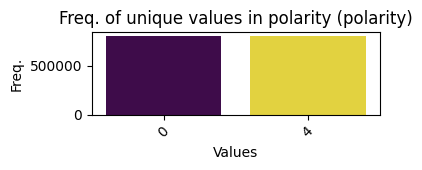

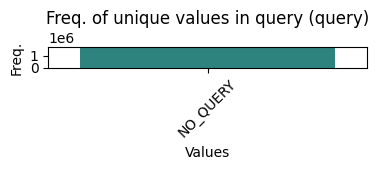

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Column translation dictionary
column_translation = {
    'polarity': 'polarity',
    'id': 'id',
    'date': 'date',
    'query': 'query',
    'user': 'user',
    'text': 'text',
}

# Visualization of unique values and their frequencies for each categorical column
for column in categorical_indicators['Column']:
    unique_values = df[column].value_counts().reset_index()
    unique_values.columns = ['value', 'count']

    # Compact bar chart
    plt.figure(figsize=(4, 1.8))
    sns.barplot(x='value', y='count', hue='value', data=unique_values, palette='viridis', legend=False)
    plt.title(f'Freq. of unique values in {column_translation[column]} ({column})')
    plt.xlabel('Values')
    plt.ylabel('Freq.')
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()


# Visualizing Text Data

In [ ]:
from collections import Counter
import re

# Function to preprocess and tokenize text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    return tokens

# Apply the function and get the most common words
df['tokens'] = df['text'].apply(preprocess_text)
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counter = Counter(all_words)
common_words = word_counter.most_common(10)
print(common_words)

[('i', 751201), ('to', 564586), ('the', 520144), ('a', 382771), ('my', 314121), ('and', 298453), ('you', 270128), ('is', 236030), ('it', 230915), ('for', 215721)]


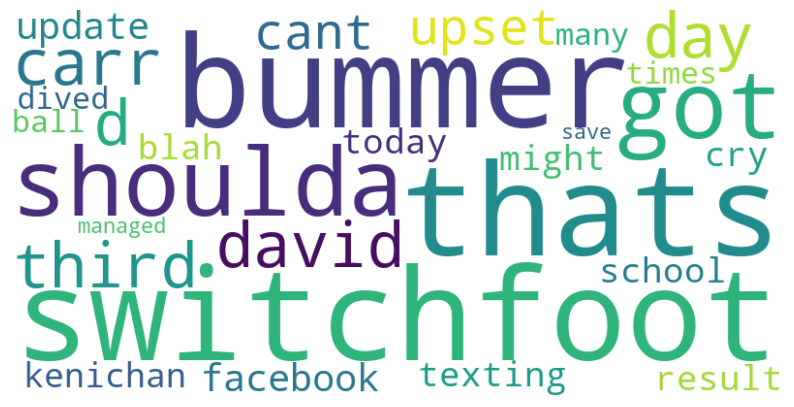

In [ ]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(all_words[:50]))

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokens and The Zipf’s law.

In [ ]:
# tqdm is a library that allows you to show a progress bar while iterating over an iterable
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer


tokenizer = get_tokenizer("basic_english")

# Tokenize all the tweets but use the tqdm library to show a progress bar
tqdm.pandas()
df['tokens'] = df['text'].progress_apply(tokenizer)


100%|██████████| 1600000/1600000 [00:10<00:00, 154026.01it/s]


### These will be the most relevant columns

In [ ]:
# reduce df to only the columns we need and text
df = df[['polarity', 'text', 'tokens']]
df.head(2)

,polarity,text,tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[@switchfoot, http, //twitpic, ., com/2y1zl, -..."
1,0,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, ', t, update, his, ..."


### Just checking tokenized texts

In [ ]:
# show the first row text and tokens
print(df['text'].iloc[0])
# show the tokens
print(df['tokens'].iloc[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['@switchfoot', 'http', '//twitpic', '.', 'com/2y1zl', '-', 'awww', ',', 'that', "'", 's', 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', 'd']


In [ ]:
# show the first row text and tokens
print(df['text'].iloc[1])
# show the tokens
print(df['tokens'].iloc[1])

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
['is', 'upset', 'that', 'he', 'can', "'", 't', 'update', 'his', 'facebook', 'by', 'texting', 'it', '.', '.', '.', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', '.', 'blah', '!']


### Counting occurrences

In [ ]:
# Count token occurrences, sorted them and put them in a list sorted_words
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counter = Counter(all_words)
sorted_words = sorted(word_counter, key=word_counter.get, reverse=True)

print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])


Number of different Tokens in our Dataset: 781063
['.', 'i', '!', "'", 'to', 'the', ',', 'a', 'my', 'it', 'and', 'you', '?', 'is', 'for', 'in', 's', 'of', 't', 'on', 'that', 'me', 'so', 'have', 'm', 'but', 'just', 'with', 'be', 'at', 'not', 'was', 'this', 'now', 'can', 'good', 'up', 'day', 'all', 'get', 'out', 'like', 'are', 'no', 'go', 'http', '-', 'today', 'do', 'too', 'your', 'going', 'work', 'love', 'we', 'got', 'what', 'lol', 'time', 'back', 'from', 'u', 'one', 'will', 'know', 'im', 'about', 'really', 'don', 'am', ')', 'had', 'see', 'some', 'there', 'its', 'how', '&amp', 'if', 'still', 'they', 'night', '&quot', '(', 'well', 'new', 'want', 'think', 'thanks', 'home', '2', 'll', 'oh', 'when', 'as', 'he', 'more', 'here', 'much', 'off']


### Checking token occurrences

In [ ]:
# Calculate the percentage of the most common words that account for the 80% of the occurrences
# This is a measure of the concentration of the vocabulary in the most common words
# The zipf's law says the most common words account for a large percentage of the occurrences

count_occurences = sum(word_counter.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
    accumulated += word_counter[sorted_words[counter]]
    counter += 1

print(f"The {counter * 100 / len(word_counter)}% most common words "
            f"account for the {accumulated * 100 / count_occurences}% of the occurrences")


The 0.11970865346329297% most common words account for the 80.00414056649427% of the occurrences


### Plotting the token occurrences

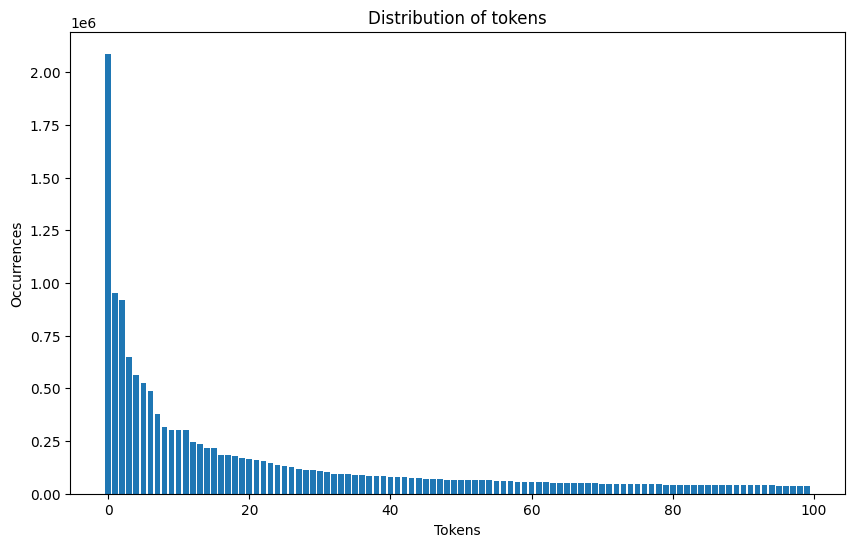

In [ ]:
# plot the distribution of the tokens using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(100), [word_counter[word] for word in sorted_words[:100]])
plt.xlabel('Tokens')
plt.ylabel('Occurrences')
plt.title('Distribution of tokens')
plt.show()